In [ ]:
#Initial ImageMagick from internet 

#Install from command line - 
#pip install opencv-python 
#pip install pillow

#install tensorflow 
#install matplotib


In [ ]:
##Magick Downloaded (Used in Bash/Command Line)
cd ImagesforModelTraining\LM19\
magick mogrify -format jpg LM19*.tif
## Change color 
magick LM19*.jpg -colorspace Gray LM19*BW.jpg
##Repeat for LM20
cd . 
cd LM20 
 magick mogrify -format jpg LM20*.tif
 magick LM20*.jpg -colorspace Gray LM20*BW.jpg

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [32]:
data_dir = "C:/Users/cccsm/praccomp2024/FinalProject/ImagesforModelTraining/ModelImages"
pathlib.Path(data_dir).with_suffix('')

WindowsPath('C:/Users/cccsm/praccomp2024/FinalProject/ImagesforModelTraining/ModelImages')

In [ ]:
batch_size = 4 ## Should we do 1 at a time?
img_height = 1024
img_width = 1024

In [34]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24 files belonging to 2 classes.
Using 20 files for training.


In [35]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24 files belonging to 2 classes.
Using 4 files for validation.


In [36]:
class_names = train_ds.class_names
print(class_names)

['LM19', 'LM20']


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

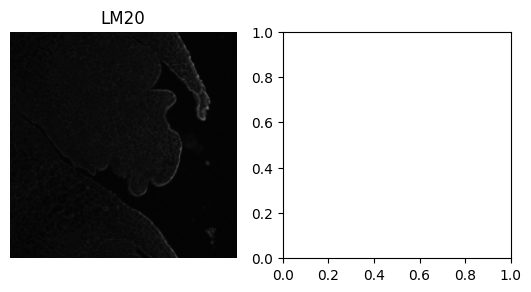

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4): ##change range from 9-4; based on Batch size
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [38]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(1, 1024, 1024, 3)
(1,)


In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.7411765


In [41]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary() 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 1024, 1024, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1024, 1024, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 512, 512, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 512, 512, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1048576)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │   134,217,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,241,698 (512.09 MB)

 Trainable params: 134,241,698 (512.09 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 587ms/step - accuracy: 0.3741 - loss: 4.1418 - val_accuracy: 0.5000 - val_loss: 0.6674
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 567ms/step - accuracy: 0.6550 - loss: 0.6272 - val_accuracy: 0.5000 - val_loss: 0.5736
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 542ms/step - accuracy: 0.9430 - loss: 0.4793 - val_accuracy: 0.7500 - val_loss: 0.8235
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 517ms/step - accuracy: 0.8263 - loss: 0.2150 - val_accuracy: 0.5000 - val_loss: 0.6522
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 520ms/step - accuracy: 0.9557 - loss: 0.0516 - val_accuracy: 0.7500 - val_loss: 1.9234
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 525ms/step - accuracy: 1.0000 - loss: 8.7754e-04 - val_accuracy: 0.7500 - val_loss: 1.7733
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 517ms/step - accuracy: 1.0000 - loss: 8.1871e-05 - val_accuracy: 0.7500 - val_loss: 1.7009
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 518ms/step - accuracy: 1.0000 - loss: 5.5116e-0

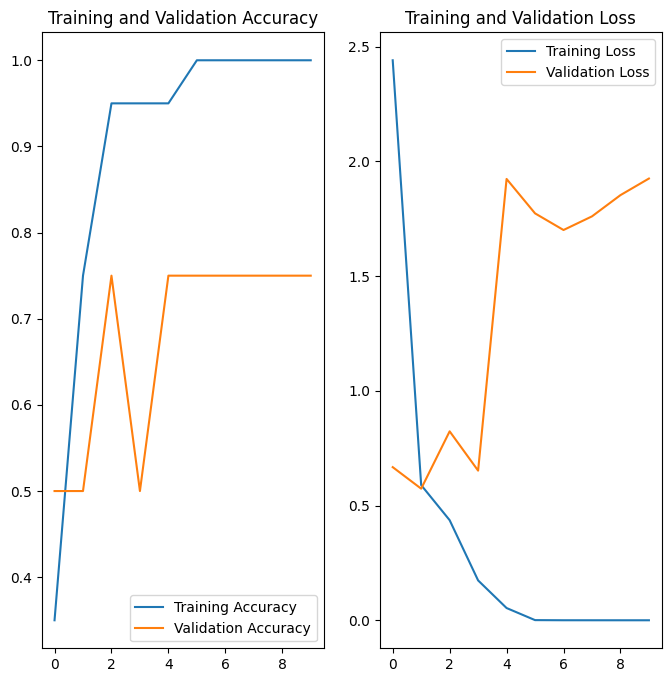

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Augment the Data itself - (Flip/Reverse to give multiple data points from the same image - looking from "different perspectives")

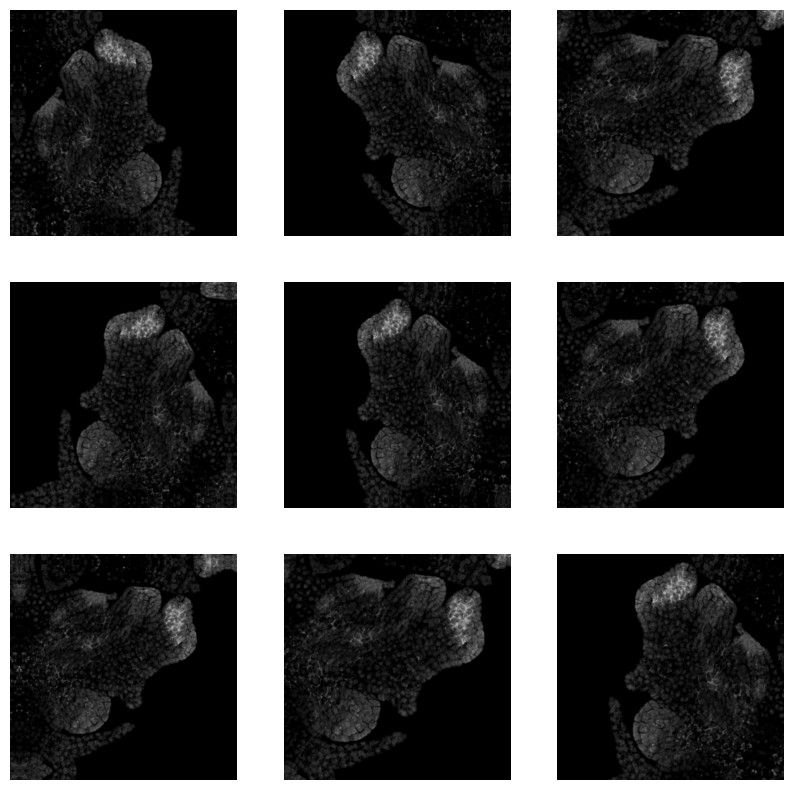

In [45]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Data Dropout for Fine Tuning - 

In [46]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 1024, 1024, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 1024, 1024, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 1024, 1024, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 512, 512, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 512, 512, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1048576)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │   134,217,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,241,698 (512.09 MB)

 Trainable params: 134,241,698 (512.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 533ms/step - accuracy: 0.5412 - loss: 6.1738 - val_accuracy: 0.5000 - val_loss: 0.7186
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 542ms/step - accuracy: 0.4061 - loss: 0.7567 - val_accuracy: 0.5000 - val_loss: 0.7043
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 546ms/step - accuracy: 0.4328 - loss: 0.6751 - val_accuracy: 0.5000 - val_loss: 0.7464
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 541ms/step - accuracy: 0.6542 - loss: 0.5701 - val_accuracy: 0.2500 - val_loss: 0.7912
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 539ms/step - accuracy: 0.7617 - loss: 0.8881 - val_accuracy: 0.5000 - val_loss: 1.0832
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 536ms/step - accuracy: 0.3864 - loss: 0.9736 - val_accuracy: 0.5000 - val_loss: 0.7867
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 542ms/step - accuracy: 0.6211 - loss: 0.4744 - val_accuracy: 0.5000 - val_loss: 0.9175
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 546ms/step - accuracy: 0.8848 - loss: 0.3135 - val_accu

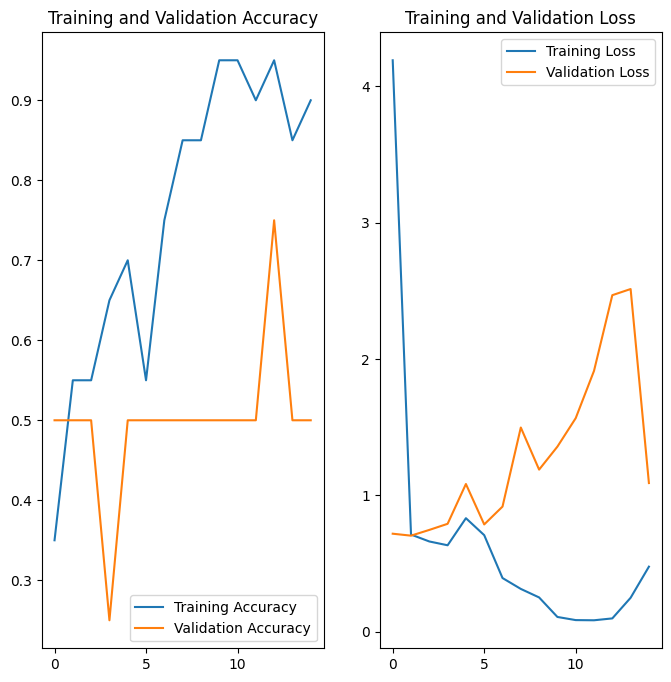

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Testing with new images

In [20]:
##Tranforming Images 
##cd directory with new images
#magick mogrify -format jpg Test*.tif #images were names Test*.tif
##to list contents of directory 
#dir 
##remove the tifs and keep the jpgs 
#del *.tif
##Convert to grayscale (Do for each file)
#magick TestLM20.jpg -colorspace Gray TestLM20BW.jpg
##Resizing Test Images 
#magick TestLM20cBW.jpg -resize 1024x1024 NTestLM20cBW.jpg 

In [49]:
LM20_path = "C:/Users/cccsm/praccomp2024/FinalProject/TestImages/NTestLM20bBW.jpg"
img = tf.keras.utils.load_img(
    LM20_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
This image most likely belongs to LM19 with a 51.04 percent confidence.


In [50]:
LM20_path = "C:/Users/cccsm/praccomp2024/FinalProject/TestImages/NTestLM20aBW.jpg"
img = tf.keras.utils.load_img(
    LM20_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
This image most likely belongs to LM19 with a 77.09 percent confidence.


In [51]:
LM20_path = "C:/Users/cccsm/praccomp2024/FinalProject/TestImages/NTestLM20cBW.jpg"
img = tf.keras.utils.load_img(
    LM20_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
This image most likely belongs to LM20 with a 87.19 percent confidence.


In [52]:
LM19_path = "C:/Users/cccsm/praccomp2024/FinalProject/TestImages/NTestLM19aBW.jpg"
img = tf.keras.utils.load_img(
    LM19_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
This image most likely belongs to LM20 with a 92.92 percent confidence.
